In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import make_smoothing_spline

class MPA2D_Spline(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_lambda=0.1):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_lambda = smoothing_lambda
        self.error_history_ = []
        self.learning_rate_history_ = []
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        np.random.seed(random_state)

    def _calculate_means(self, X, y):
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        self.control_x = np.linspace(x_min, x_max, self.n_control_points).copy()  # Make it adjustable
        y_mid = (self.m0[1] + self.m1[1]) / 2
        self.control_y = np.random.uniform(y_mid - (y_max - y_min) * 0.1,
                                          y_mid + (y_max - y_min) * 0.1,
                                          self.n_control_points)
        self.initial_control_x = self.control_x.copy()  # Store initial x too
        self.initial_control_y = self.control_y.copy()

    def _fit_spline(self):
        self.spline = make_smoothing_spline(self.control_x, self.control_y, lam=self.smoothing_lambda)

    def _calculate_displacement(self, X):
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")
        X = np.asarray(X)
        y = np.asarray(y)

        self._calculate_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        self.error_history_ = []
        self.learning_rate_history_ = []

        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        for epoch in range(self.epochs):
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min LR reached at epoch {epoch}")
                        break

            if errors.any():
                error_indices = np.where(errors)[0]
                for idx in error_indices:
                    d = X[idx]
                    distances = np.abs(self.control_x - d[0])
                    nearest_idx = np.argmin(distances)
                    distance = distances[nearest_idx]
                    lmbda = (np.log1p(distance) if self.lambda_scaling == 'log' else
                            np.sqrt(distance) if self.lambda_scaling == 'sqrt' else distance)

                    # Determine opposite class's correctly classified points
                    if y[idx] == 1:  # Misclassified class 1 point
                        opp_indices = indices_class_0
                    else:  # Misclassified class 0 point
                        opp_indices = indices_class_1

                    # Find correctly classified points in opposite class
                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > 0]

                    if len(correct_opp) > 0:
                        # Average 2D position of correctly classified opposite class points
                        avg_opp = np.mean(X[correct_opp], axis=0)  # [avg_opp_x, avg_opp_y]
                        # Calculate 2D difference to move towards avg_opp
                        delta_x = avg_opp[0] - self.control_x[nearest_idx]
                        delta_y = avg_opp[1] - self.control_y[nearest_idx]
                        # Apply step in both directions
                        step_x = delta_x * lmbda * current_learning_rate
                        step_y = delta_y * lmbda * current_learning_rate

                        # Constrain step_x to maintain ascending order
                        if nearest_idx > 0:
                            min_x = self.control_x[nearest_idx - 1] + 1e-6  # Small buffer to avoid equality
                            step_x = max(step_x, min_x - self.control_x[nearest_idx])
                        if nearest_idx < len(self.control_x) - 1:
                            max_x = self.control_x[nearest_idx + 1] - 1e-6
                            step_x = min(step_x, max_x - self.control_x[nearest_idx])
                    else:
                        # Fallback: Use original direction (y-only) if no correct points
                        step_x = 0  # No x movement in fallback
                        step_y = -pseudo_labels[idx] * lmbda * current_learning_rate

                    self.control_x[nearest_idx] += step_x
                    self.control_y[nearest_idx] += step_y

        # Store the last control points from the final epoch
        self.last_control_x = self.control_x.copy()
        self.last_control_y = self.control_y.copy()
        # Restore best for prediction
        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def plot_convergence(self, figsize=(12, 5)):
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)
            plt.tight_layout()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def plot_boundary(self, X, y, figsize=(8, 6)):
        try:
            import matplotlib.pyplot as plt
            fig = plt.figure(figsize=figsize)
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)

            # Plot initial spline
            initial_spline = make_smoothing_spline(self.initial_control_x, self.initial_control_y, lam=self.smoothing_lambda)
            x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
            y_initial = initial_spline(x_range)
            plt.plot(x_range, y_initial, 'r--', label='Initial Boundary', alpha=0.7)

            # Plot last spline (from final epoch)
            last_spline = make_smoothing_spline(self.last_control_x, self.last_control_y, lam=self.smoothing_lambda)
            y_last = last_spline(x_range)
            plt.plot(x_range, y_last, 'g-', label='Last Boundary')

            # Plot control points
            plt.scatter(self.initial_control_x, self.initial_control_y, c='orange', marker='o', label='Initial Control Points', alpha=0.7)
            plt.scatter(self.last_control_x, self.last_control_y, c='k', marker='x', label='Last Control Points')

            plt.legend()
            plt.title('MPA2D_Spline Decision Boundary: Initial vs Last')
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

In [2]:
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

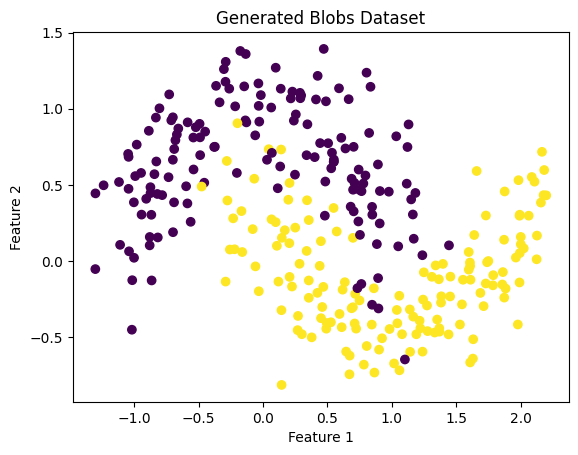

In [3]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.20)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [4]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [5]:
# Initialize and fit the model
model = MPA2D_Spline(
    learning_rate=0.001,
    epochs=35,
    verbose=True,
    n_control_points=7,
    smoothing_lambda=0.00001,
    decay_factor=0.99,
    random_state = 11
)

In [6]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 40, LR = 0.001000
Epoch 10: Errors = 40, LR = 0.000990
Epoch 20: Errors = 24, LR = 0.000990
Epoch 30: Errors = 20, LR = 0.000990


MPA2D_Spline(decay_factor=0.99, epochs=35, learning_rate=0.001,
             n_control_points=7, random_state=11, smoothing_lambda=1e-05,
             verbose=True)

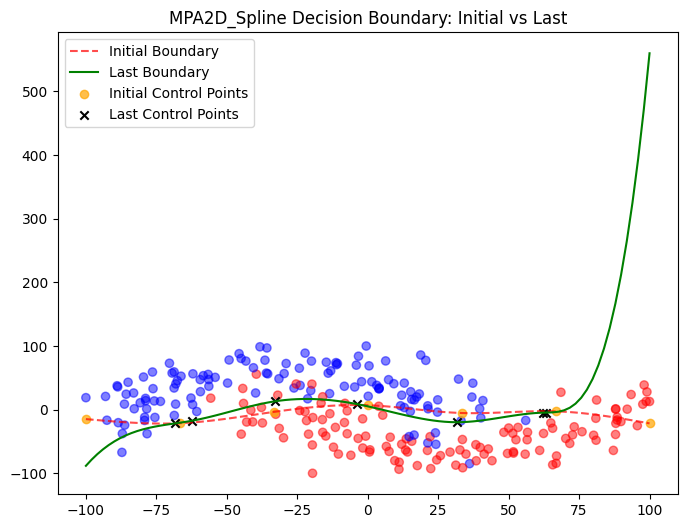

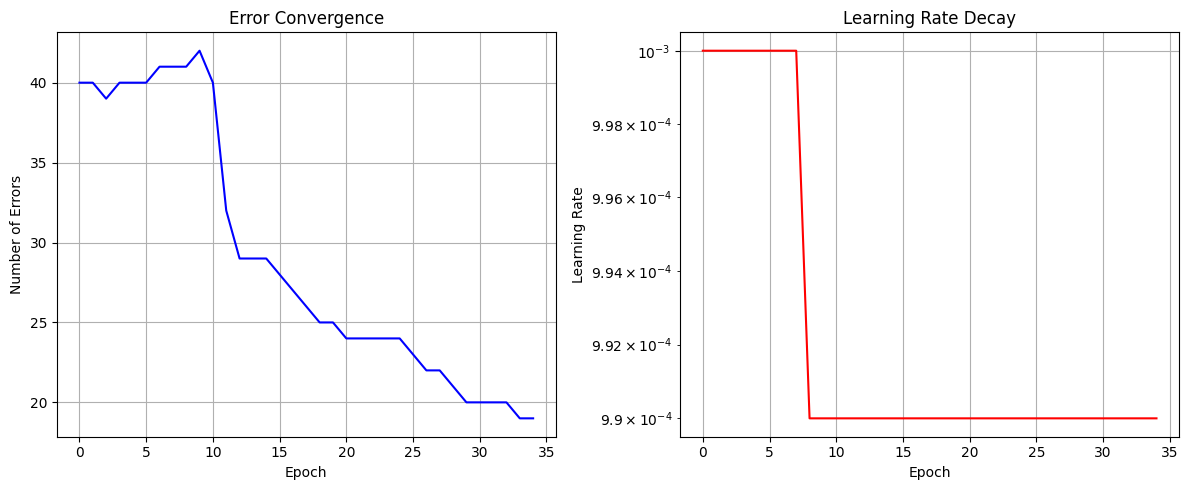

In [7]:
# Plot the decision boundary and convergence
model.plot_boundary(X_train_minmax, y_train)
model.plot_convergence()
plt.show()

In [8]:
from sklearn.metrics import classification_report

In [9]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.94      1.00      0.97        32

    accuracy                           0.97        60
   macro avg       0.97      0.96      0.97        60
weighted avg       0.97      0.97      0.97        60



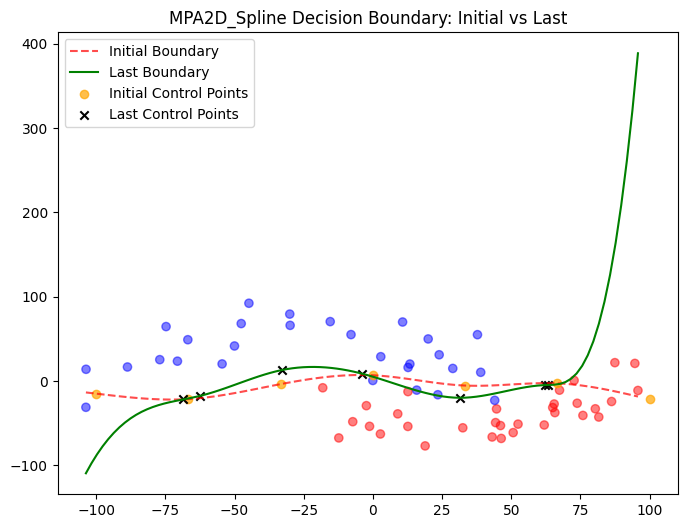

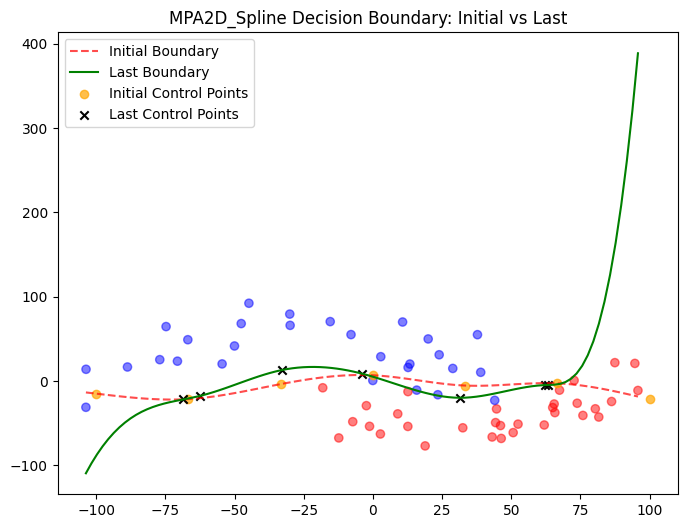

In [10]:
model.plot_boundary(X_test_minmax, y_test)

In [11]:
def generate_spiral_dataset(n_points=200, noise=0.1):
    """
    Generate a two-class spiral dataset.
    
    Parameters:
    -----------
    n_points : int, default=200
        Number of points to generate for each class
    noise : float, default=0.1
        Amount of noise to add to the dataset
    
    Returns:
    --------
    X : numpy.ndarray
        Feature matrix with shape (2*n_points, 2)
    y : numpy.ndarray
        Target labels with shape (2*n_points,)
    """
    # Generate points for each spiral
    n = n_points
    n_per_half = n // 2
    
    # First spiral (class 0)
    theta = np.linspace(0, 4*np.pi, n_per_half)
    radius = theta
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    
    # Second spiral (class 1)
    theta = np.linspace(0, 4*np.pi, n_per_half)
    radius = theta
    x2 = radius * np.cos(theta + np.pi)
    y2 = radius * np.sin(theta + np.pi)
    
    # Combine and add noise
    X = np.vstack([
        np.column_stack([x1, y1]),
        np.column_stack([x2, y2])
    ])
    y = np.hstack([
        np.zeros(n_per_half),
        np.ones(n_per_half)
    ])
    
    # Add Gaussian noise
    X += np.random.normal(0, noise, X.shape)
    
    return X, y

def plot_spiral_dataset(X, y):
    """
    Visualize the generated spiral dataset.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Target labels
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1')
    plt.title('Spiral Dataset')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

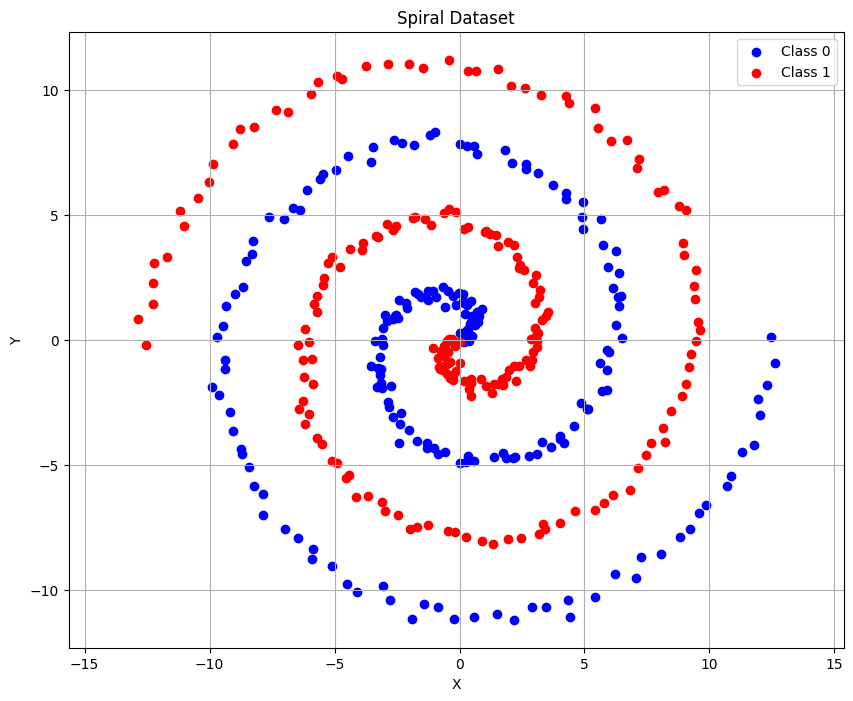

In [12]:
X, y = generate_spiral_dataset(n_points=400, noise=0.2)
plot_spiral_dataset(X, y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [14]:
# Initialize and fit the model
model = MPA2D_Spline(
    learning_rate=0.001,
    epochs=50,
    verbose=True,
    n_control_points=50,
    smoothing_lambda=0.00001,
    decay_factor=0.99,
    random_state = 11
)

In [15]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 142, LR = 0.001000
Epoch 10: Errors = 143, LR = 0.000990
Epoch 20: Errors = 145, LR = 0.000970
Epoch 30: Errors = 144, LR = 0.000951
Epoch 40: Errors = 141, LR = 0.000932


MPA2D_Spline(decay_factor=0.99, learning_rate=0.001, n_control_points=50,
             random_state=11, smoothing_lambda=1e-05, verbose=True)

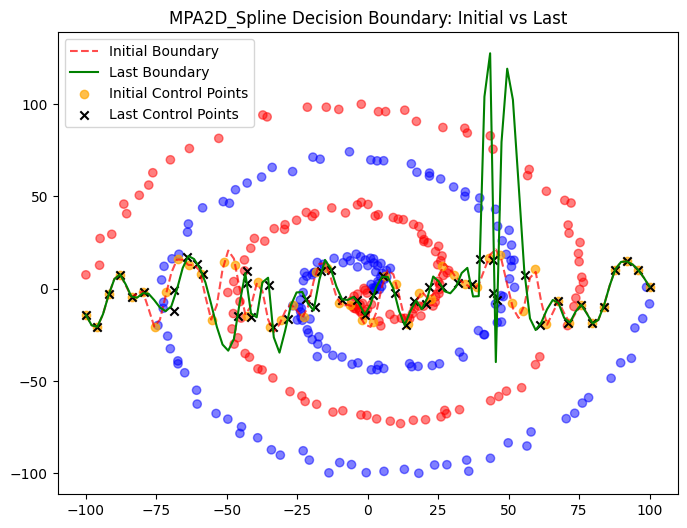

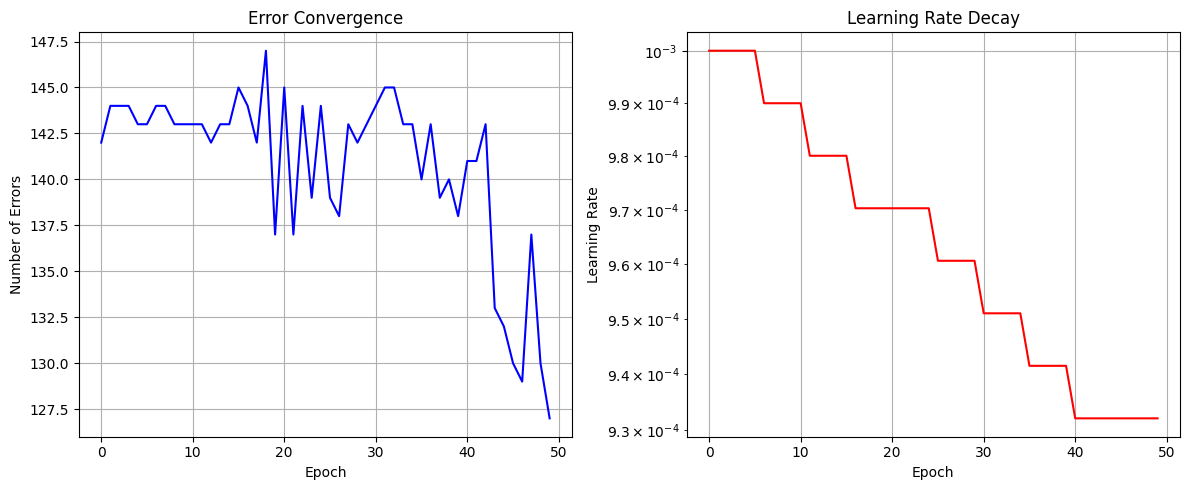

In [16]:
# Plot the decision boundary and convergence
model.plot_boundary(X_train_minmax, y_train)
model.plot_convergence()
plt.show()

In [17]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.38      0.41        34
         1.0       0.58      0.63      0.60        46

    accuracy                           0.53        80
   macro avg       0.51      0.51      0.51        80
weighted avg       0.52      0.53      0.52        80



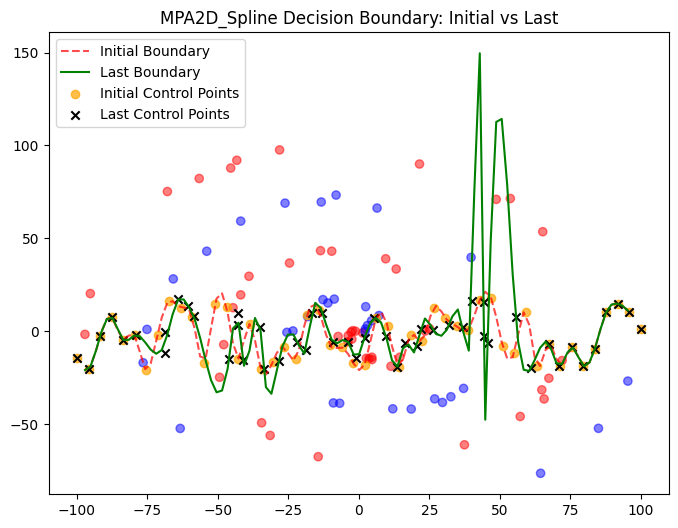

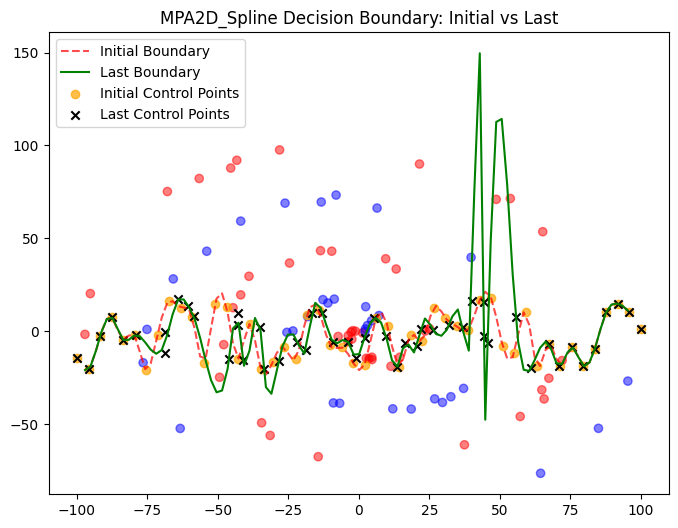

In [18]:
model.plot_boundary(X_test_minmax, y_test)